In [ ]:
# Install packages
# Remember to Restart runtime after installation

# Change the versions to match the ones present in the docker image
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
!pip install graphviz
!pip install tornado==6.1
!pip install coiled==0.0.76
!pip install dask==2022.03.0
!pip install distributed==2022.3.0
!pip install boto3
!pip install jupyter
!pip install pandas==1.4.3
!pip install numpy==1.21.5
!pip install lz4==4.0.0
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install git+https://github.com/uncbiag/OAI_analysis_2.git#egg=oai_package

In [ ]:
# All Imports

import coiled
import dask
from dask import compute, visualize, delayed

import itk
import vtk
import itkwidgets
from oai_analysis_2 import dask_processing as dp
import matplotlib.pyplot as plt

In [2]:
# Create Coiled Cluster with 2 workers

name = 'oai-processing21'

cluster = coiled.Cluster(
    n_workers=4,
    scheduler_cpu=4,
    scheduler_memory="16 GiB",
    worker_cpu=4,
    worker_memory="16 GiB",
    worker_gpu=1,
    name=name,
    worker_class="dask_cuda.CUDAWorker",
    software="gpu-test9",
)

client = dask.distributed.Client(cluster)

cluster

Output()

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-pranjal09-154052-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-154052-firewall -> coiled-dask-pranjal09-154052-firewall]
Created FW rules: coiled-dask-pranjal09-154052-cluster-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-154052-cluster-firewall -> coiled-dask-pranjal09-154052-cluster-firewall]
Created scheduler VM: coiled-dask-pranjal09-154052-scheduler (type: t3.xlarge, ip: ['54.196.182.122'])


Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | client         | scheduler      | workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.0.0          | 2.1.0          | 2.1.0          |
| pandas      | 1.3.1          | 1.4.2          | 1.4.2          |
| python      | 3.8.12.final.0 | 3.9.13.final.0 | 3.9.13.final.0 |
+-------------+----------------+----------------+----------------+


In [75]:
# Main execution block

all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'

for month in months_array:
    image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

    fc_probmap, tc_probmap = dp.segment_method(image_path)
    phi_AB, image_A, image_B = dp.register_images_delayed(
        image_path, 'atlas_image.nii.gz')

    deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            fc_probmap, 'FC')
    deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            tc_probmap, 'TC')

    thickness_fc = dp.get_thickness(deformed_fc, 'FC')
    thickness_tc = dp.get_thickness(deformed_tc, 'TC')

    result = [thickness_fc, thickness_tc]

    all_results.append(result)

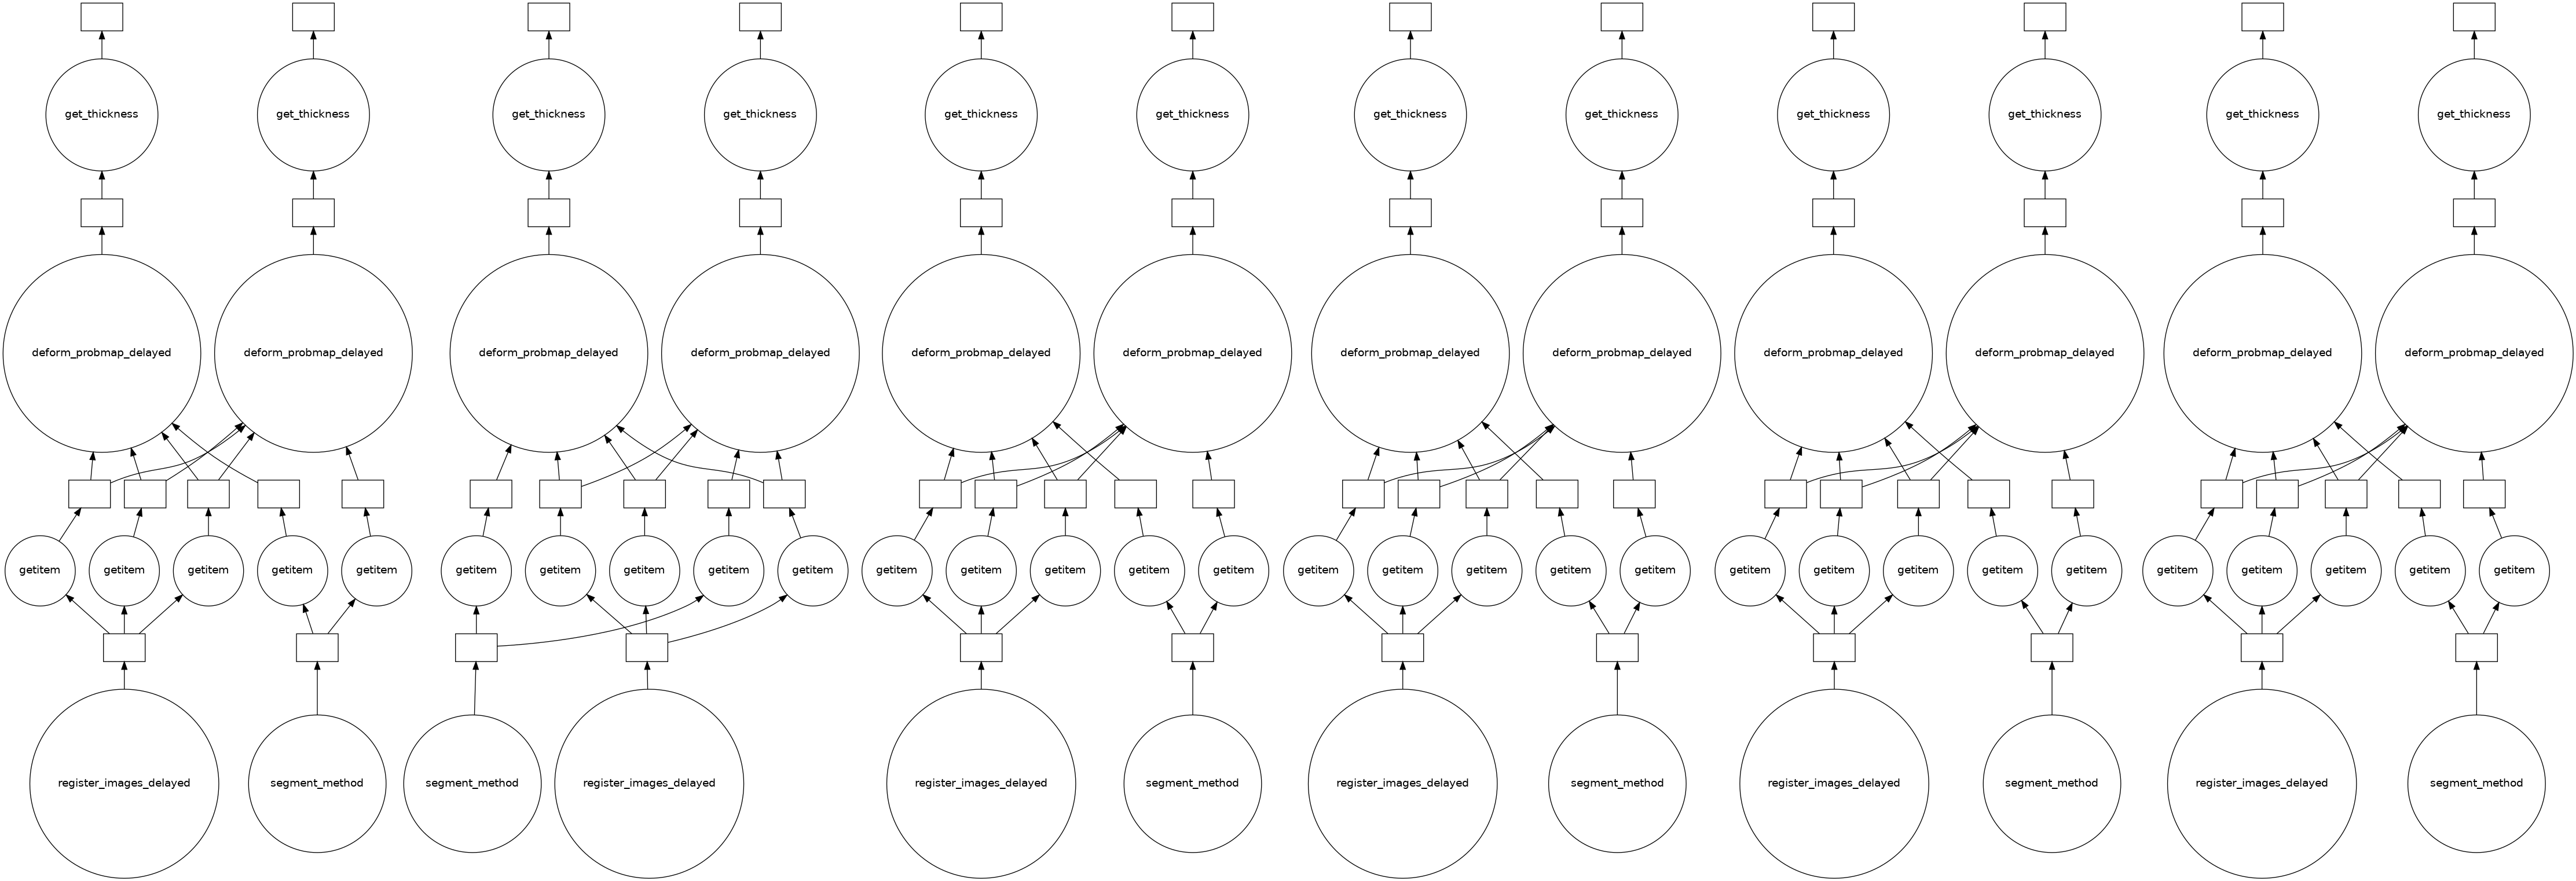

In [76]:
# Visualize Dask Computation Graph

visualize(*all_results)

In [77]:
%%time

output_result = compute(*all_results)

CPU times: user 228 ms, sys: 71.8 ms, total: 300 ms
Wall time: 1min 57s


In [78]:
# Write the meshes as vtk files

for i in range(len(output_result)):
    distance_inner_FC = itk.mesh_from_dict(output_result[i][0])
    distance_inner_TC = itk.mesh_from_dict(output_result[i][1])

    itk.meshwrite(distance_inner_FC, months_array[i]+'_itk_distance_inner_FC.vtk')
    itk.meshwrite(distance_inner_TC, months_array[i]+'_itk_distance_inner_TC.vtk')

In [79]:
# Read the meshes for viewing

month = months_array[5]

v1 = vtk.vtkPolyDataReader()
v1.SetFileName(month+'_itk_distance_inner_FC.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName(month+'_itk_distance_inner_TC.vtk')
v2.Update()
m2 = v2.GetOutput()

In [80]:
# Visualize the meshes

itkwidgets.view(geometries=[m1, m2])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [10]:
#cluster.close()

Cluster deleted successfully.

2022-06-04 15:12:21,105 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [88]:
# [STAR] Start Cluster

import coiled
import dask
from dask import compute, visualize, delayed

cluster = coiled.Cluster(
    name='gpucluster17',
    scheduler_vm_types=['t3.medium'],
    worker_vm_types=["g4dn.2xlarge", "p3.2xlarge", "p2.xlarge", "g5.2xlarge"],
    #worker_vm_types=["p3.2xlarge", "p2.xlarge", "g5.2xlarge"],
    n_workers=8,
    software="pranjal-sahu/gpu-test11",
    #worker_options=dict(resources=dict(GPU=1)),
    #worker_class='dask_cuda.CUDAWorker',
    shutdown_on_close=True,
)

client = dask.distributed.Client(cluster)

Output()

In [ ]:
# [STAR] Main execution loop

import itk
import coiled
import dask
from dask import compute, visualize, delayed

atlas_path = "s3://oaisample1/ZARRDATA/atlas_image.zarr/scale0"

#patient_id = '9000798'  # bad
#patient_id = '9016304'  # good
#patient_id = '9040390' # moderate
#patient_id = '9210505' # good
#patient_d = '9283903' # good
#patient_id = '9305065' # good
#patient_id = '9261513' # good
#patient_id = '9247140' # good
#patient_id = '9128011' # good
#patient_id = '9068305' # good
patient_id = '9094865'

#patients_array = [patient_id]#['9016304', '9040390']

# Less number of months:
check_cases = ['9322401', '9125977', '9299531', '9041946', '9223980']

# Performed processing already
done_already = [
    '9283903', '9094865', '9290211', '9171580', '9214480', '9208055',
    '9000798', '9138965', '9246995', '9291234', '9068305', '9101854',
    '9316405', '9305065', '9075815', '9036316', '9155449', '9247140',
    '9128011', '9297051', '9285212', '9054866', '9007827', '9261513',
    '9263504', '9037823', '9021791', '9210505', '9239017', '9268652', 
    '9135902', '9252629', '9028786', '9277154', '9103365', 
    '9016304', '9233675', '9235073', '9212530', '9040390'
]

patients_array = done_already#[]

months_array = [
    'Month-0', 'Month-12', 'Month-24', 'Month-36', 'Month-48', 'Month-72',
    'Month-96'
]


#@delayed
def readimage(image_path):
    #import itkConfig
    #itkConfig.LazyLoading = False
    import itk
    from itk import CastImageFilter as CastImageFilter
    #from itk import cast_image_filter
    import xarray as xr
    xr_dataset = xr.open_zarr(image_path)
    xr_array = xr_dataset.get('image')
    itk_image = itk.image_from_xarray(xr_array)

    cast_filter_type = CastImageFilter[type(itk_image),
                                           itk.Image[itk.F, 3]].New()
    cast_filter_type.SetInPlace(False)
    cast_filter_type.SetInput(itk_image)
    cast_filter_type.Update()
    itk_image = cast_filter_type.GetOutput()
    return itk_image


@delayed(nout=2)
def segment_method(image_A):
    import itk
    from itk import IntensityWindowingImageFilter as IntensityWindowingImageFilter
    import oai_analysis_2
    import torch
    import os
    from os.path import exists
    from oai_analysis_2 import utils
    from oai_analysis_2.segmentation import segmenter
    #import itkConfig
    #itkConfig.LazyLoading = False
    import time
    import numpy as np
    import os
    import urllib.request
    import gc

    def image_normalize(image, window_min_perc, window_max_perc, output_min,
                        output_max):
        window_rescale = IntensityWindowingImageFilter[type(image),
                                                           type(image)].New()
        image_array = itk.GetArrayFromImage(image)

        window_min = np.percentile(image_array, window_min_perc)
        window_max = np.percentile(image_array, window_max_perc)

        window_rescale.SetInput(image)
        window_rescale.SetOutputMaximum(output_max)
        window_rescale.SetOutputMinimum(output_min)
        window_rescale.SetWindowMaximum(window_max)
        window_rescale.SetWindowMinimum(window_min)
        window_rescale.Update()

        return window_rescale.GetOutput()

    if torch.cuda.is_available():
        device = "cuda"
        torch.cuda.empty_cache()
    else:
        print("WARNING: CUDA NOT AVAILABLE, FALLING BACK TO CPU")
        device = "cpu"

    if not exists("segmentation_model.pth.tar"):
        print("Downloading segmentation model")
        urllib.request.urlretrieve(
            "https://github.com/uncbiag/OAI_analysis_2/blob/master/data/segmentation_model.pth.tar?raw=true",
            "segmentation_model.pth.tar")

    if not exists("segmentation_train_config.pth.tar"):
        urllib.request.urlretrieve(
            "https://github.com/uncbiag/OAI_analysis_2/blob/master/data/segmentation_train_config.pth.tar?raw=true",
            "segmentation_train_config.pth.tar")

    # Initialize segmenter
    segmenter_config = dict(
        ckpoint_path="segmentation_model.pth.tar",
        training_config_file="segmentation_train_config.pth.tar",
        device=device,
        batch_size=2,
        overlap_size=(16, 16, 8),
        output_prob=True,
        output_itk=True,
    )

    segmenter = oai_analysis_2.segmentation.segmenter.Segmenter3DInPatchClassWise(
        mode="pred", config=segmenter_config)

    # Segment downloaded image
    test_volume = readimage(image_A)

    test_volume = image_normalize(test_volume, 0.1, 99.9, 0, 1)

    FC_probmap, TC_probmap = segmenter.segment(test_volume,
                                               if_output_prob_map=True,
                                               if_output_itk=True)

    del segmenter
    gc.collect()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return FC_probmap, TC_probmap


@delayed(nout=3)
def register_images_delayed(image_A, image_B):
    #import itkConfig
    #itkConfig.LazyLoading = False
    import itk
    from itk import CastImageFilter as CastImageFilter
    from itk import IntensityWindowingImageFilter as IntensityWindowingImageFilter
    import icon_registration
    import icon_registration.itk_wrapper as itk_wrapper
    import icon_registration.pretrained_models as pretrained_models
    from os.path import exists
    import torch
    import xarray as xr
    import time
    import numpy as np
    import gc

    def image_normalize(image, window_min_perc, window_max_perc, output_min,
                        output_max):
        window_rescale = IntensityWindowingImageFilter[type(image),
                                                           type(image)].New()
        image_array = itk.GetArrayFromImage(image)

        window_min = np.percentile(image_array, window_min_perc)
        window_max = np.percentile(image_array, window_max_perc)

        window_rescale.SetInput(image)
        window_rescale.SetOutputMaximum(output_max)
        window_rescale.SetOutputMinimum(output_min)
        window_rescale.SetWindowMaximum(window_max)
        window_rescale.SetWindowMinimum(window_min)
        window_rescale.Update()

        return window_rescale.GetOutput()
    
    image_A = readimage(image_A)
    image_B = readimage(image_B)
    
    cast_filter_type = CastImageFilter[type(image_A), itk.Image[itk.D,
                                                                    3]].New()
    cast_filter_type.SetInPlace(False)
    cast_filter_type.SetInput(image_A)
    cast_filter_type.Update()
    image_A = cast_filter_type.GetOutput()

    cast_filter_type = CastImageFilter[type(image_B), itk.Image[itk.D,
                                                                    3]].New()
    cast_filter_type.SetInPlace(False)
    cast_filter_type.SetInput(image_B)
    cast_filter_type.Update()
    image_B = cast_filter_type.GetOutput()

    image_A = image_normalize(image_A, 0.1, 99.9, 0, 1)

    model = pretrained_models.OAI_knees_gradICON_model()
    if torch.cuda.is_available():
        model.cuda()
        torch.cuda.empty_cache()
    else:
        model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)

    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return phi_AB, image_A, image_B


@delayed
def deform_probmap_delayed(phi_AB, image_A, image_B, prob, image_type='FC'):
    #import itkConfig
    #itkConfig.LazyLoading = False
    import itk
    from itk import LinearInterpolateImageFunction
    #phi_AB1 = itk.transform_from_dict(phi_AB)

    interpolator = LinearInterpolateImageFunction.New(image_A)
    warped_image = itk.resample_image_filter(
        prob,
        transform=phi_AB,
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin())

    return warped_image


@delayed(nout=1)
def get_thickness(warped_image, mesh_type):
    #import itkConfig
    #itkConfig.LazyLoading = False
    import itk
    import vtk
    import numpy as np
    import os
    from oai_analysis_2 import mesh_processing as mp

    def cluster_and_segment(mesh_centroids_normalized, face_normal_value,
                            dot_output):
        features = np.concatenate(
            (mesh_centroids_normalized * 10, face_normal_value, dot_output),
            axis=1)
        est1 = KMeans(n_clusters=2, algorithm="full", n_init=5)
        labels_upper = est1.fit(features).labels_
        labels_upper = labels_upper * 2 - 1

        # set inner surface which contains mostly positive normals
        if face_normal_value[labels_upper == -1, 1].mean() < 0:
            labels_upper = -labels_upper

        return labels_upper

    def get_itk_mesh(vtk_mesh):
        Dimension = 3
        PixelType = itk.D

        # Get points array from VTK mesh
        points = vtk_mesh.GetPoints().GetData()
        points_numpy = np.array(points).flatten()  #.astype('float32')

        polys = vtk_mesh.GetPolys().GetData()
        polys_numpy = np.array(polys).flatten()

        # Triangle Mesh
        vtk_cells_count = vtk_mesh.GetNumberOfPolys()
        polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension + 1])

        # Extracting only the points by removing first column that denotes the VTK cell type
        polys_numpy = polys_numpy[:, 1:]
        polys_numpy = polys_numpy.flatten().astype(np.uint64)

        # Get point data from VTK mesh to insert in ITK Mesh
        point_data_numpy = np.array(
            vtk_mesh.GetPointData().GetScalars())  #.astype('float64')

        # Get cell data from VTK mesh to insert in ITK Mesh
        cell_data_numpy = np.array(
            vtk_mesh.GetCellData().GetScalars())  #.astype('float64')

        MeshType = itk.Mesh[PixelType, Dimension]
        itk_mesh = MeshType.New()

        itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
        itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy),
                               itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
        itk_mesh.SetPointData(
            itk.vector_container_from_array(point_data_numpy))
        itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))
        return itk_mesh

    def get_mesh1(itk_image, num_iterations=150):
        import skimage

        spacing = itk_image.GetSpacing()
        img_array = np.swapaxes(np.asarray(itk_image), 0, 2).astype(float)

        # Obtain the mesh from Probability maps using Marching Cubes
        verts, faces, normals, values = skimage.measure.marching_cubes(
            img_array,
            level=0.5,
            spacing=spacing,
            step_size=1,
            gradient_direction="ascent")

        mesh = mp.get_vtk_mesh(verts, faces)

        # For smoothing the mesh surface to obtain gradually varying face normals
        mesh = mp.smooth_mesh(mesh, num_iterations=num_iterations)
        return mesh

    def split_femoral_cartilage_surface(mesh, mesh_cell_normals,
                                        mesh_cell_centroids):
        # Split the mesh
        import vtk
        import itk
        import vtk.util.numpy_support as nps

        #center = np.mean(mesh_cell_centroids, axis=0)
        center_min = np.min(mesh_cell_centroids, axis=0)
        center_max = np.max(mesh_cell_centroids, axis=0)
        center = (center_min + center_max) / 2

        targetPolydata = vtk.vtkPolyData()
        targetPolydata.SetPoints(mesh.GetPoints())
        targetPolydata.SetPolys(mesh.GetPolys())

        # set up locater for intersection with normal vector rays
        obbTree = vtk.vtkOBBTree()
        obbTree.SetDataSet(targetPolydata)
        obbTree.BuildLocator()

        outer_list = []
        inner_list = []
        for i in range(mesh.GetNumberOfPoints()):
            rayEndPoint = targetPolydata.GetPoint(i)
            intersectionIds = vtk.vtkIdList()
            intersectionPoints = vtk.vtkPoints()
            k1 = rayEndPoint
            obbTree.IntersectWithLine([k1[0], k1[1], k1[2]],
                                      [center[0], center[1], center[2]],
                                      intersectionPoints, intersectionIds)
            #obbTree.IntersectWithLine([center[0], center[1], center[2]], [k1[0], k1[1], k1[2]],
            #                         intersectionPoints, intersectionIds)
            if intersectionPoints.GetNumberOfPoints() <= 1:
                for k in range(intersectionIds.GetNumberOfIds()):
                    inner_list.append(intersectionIds.GetId(k))

        inner_face_list = set(inner_list)
        all_list = set(np.arange(0, mesh_cell_normals.shape[0]))
        outer_face_list = all_list - inner_face_list

        inner_face_list = list(inner_face_list)
        outer_face_list = list(outer_face_list)
        inner_mesh = mp.get_vtk_sub_mesh(mesh, inner_face_list)
        outer_mesh = mp.get_vtk_sub_mesh(mesh, outer_face_list)

        return inner_mesh, outer_mesh, inner_face_list, outer_face_list

    # To obtain inner and outer mesh splits given the mesh type
    def split_mesh(mesh, mesh_type='FC'):
        # Obtain the cell normals and centroids to be used for splittig the cartilage
        mesh_cell_normals = mp.get_cell_normals(mesh)
        mesh_cell_centroids = mp.get_cell_centroid(mesh)

        # Split the mesh
        if mesh_type == 'FC':
            inner_mesh, outer_mesh, inner_face_list, outer_face_list = split_femoral_cartilage_surface(
                mesh, mesh_cell_normals, mesh_cell_centroids)
        else:
            inner_mesh, outer_mesh, inner_face_list, outer_face_list = mp.split_tibial_cartilage_surface(
                mesh, mesh_cell_normals, mesh_cell_centroids)

        return inner_mesh, outer_mesh

    def get_thickness_mesh(itk_image, mesh_type='FC', num_iterations=150):
        '''
        Takes the probability map obtained from the segmentation algorithm as an itk image.
        Constructs a VTK mesh from it and returns the thickness between the inner and outer splitted mesh.
        Takes as argument the type of mesh 'FC' or 'TC'.
        '''
        # Get mesh from itk image
        mesh = get_mesh1(itk_image, num_iterations=150)

        # Split the mesh into inner and outer
        inner_mesh, outer_mesh = mp.split_mesh(mesh, mesh_type)

        # Get the distance between inner and outer mesh
        distance_inner, distance_outer = mp.get_distance(
            inner_mesh, outer_mesh)
        return distance_inner, distance_outer

    distance_inner, distance_outer = get_thickness_mesh(warped_image,
                                                        mesh_type=mesh_type)
    distance_inner_itk = mp.get_itk_mesh(distance_inner)
    return distance_inner_itk


all_result = []
counter = 0

print(time.time())
random.shuffle(patients_array)
#patient_id_array = []
for patient_id in patients_array:
    import time
    print('Processing ', patient_id, time.time())
    patient_result = []
    for month in months_array:
        image_path = "s3://oaisample1/ZARRDATA/PatientID-" + patient_id + '/' + month + '/Images/SAG_3D_DESS_0.zarr/scale0'

        #out = readimage(image_path)
        #atlas_image = readimage(atlas_path)

        fc_probmap, tc_probmap = segment_method(image_path)
        phi_AB, image_A, image_B = register_images_delayed(image_path, atlas_path)

        deformed_fc = deform_probmap_delayed(phi_AB, image_A, image_B,
                                             fc_probmap, 'FC')
        deformed_tc = deform_probmap_delayed(phi_AB, image_A, image_B,
                                             tc_probmap, 'TC')
        thickness_fc = get_thickness(deformed_fc, 'FC')
        thickness_tc = get_thickness(deformed_tc, 'TC')
        
        patient_result.append([thickness_fc, thickness_tc])
        #result = [deformed_fc, deformed_tc]
        #result = [thickness_fc]# thickness_fc]  # thickness_tc]
    
    output_result = compute(*patient_result)
    for result in output_result:
        itk.meshwrite(
            result[0], '/data/OAIFULLDATA/RESULTS1/' + patient_id + '_' +
            str(counter) + '_itk_distance_inner_FC.vtk')
        itk.meshwrite(
            result[1], '/data/OAIFULLDATA/RESULTS1/' + patient_id + '_' +
            str(counter) + '_itk_distance_inner_TC.vtk')
        counter = counter + 1
    
print(time.time())
    #all_result.append(output_result)


#itk.meshwrite(output_result[0][0], 'itk_distance_inner_FC.vtk')
#itk.meshwrite(output_result[0][1], 'itk_distance_inner_TC.vtk')

1659900929.5304165
Processing  9285212 1659900929.5306716
Processing  9155449 1659901050.509086
Processing  9210505 1659901148.89942
Processing  9101854 1659901268.611555
Processing  9016304 1659901392.6387062
Processing  9037823 1659901507.7733772
Processing  9246995 1659901611.638307
Processing  9138965 1659901732.9260964
Processing  9305065 1659901843.9763527
Processing  9007827 1659901967.147646
Processing  9212530 1659902056.8848386
Processing  9054866 1659902176.1629083
Processing  9290211 1659902272.5848706


Task exception was never retrieved
future: <Task finished name='Task-5185' coro=<Cluster._sync_cluster_info() done, defined at /home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-packages/distributed/deploy/cluster.py:120> exception=OverflowError(34, 'Numerical result out of range')>
Traceback (most recent call last):
  File "/home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-packages/distributed/deploy/cluster.py", line 154, in _sync_cluster_info
    interval = min(max_interval, self._sync_interval * 1.5**err_count)
OverflowError: (34, 'Numerical result out of range')


Processing  9094865 1659902389.1203563


2022-08-07 15:59:49,760 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f2c9ca42d60>>, <Task finished name='Task-54165' coro=<ClusterBeta._close() done, defined at /home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-packages/coiled/context.py:68> exception=OverflowError(34, 'Numerical result out of range')>)
Traceback (most recent call last):
  File "/home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-packages/tornado/ioloop.py", line 765, in _discard_future_result
    future.result()
  File "/home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-packages/coiled/context.py", line 77, in wrapper
    return await func(*args, **kwargs)
  File "/home/pranjal.sahu/anaconda3/envs/ethicon/lib/python3.8/site-pack

Processing  9263504 1659902486.7078362
Processing  9103365 1659902600.8411863
Processing  9068305 1659902717.8310137
Processing  9235073 1659902837.046833
Processing  9261513 1659902942.192596
Processing  9297051 1659903063.7655637
Processing  9233675 1659903165.0026221
Processing  9247140 1659903283.421986
Processing  9135902 1659903399.789647
Processing  9028786 1659903515.007239


In [86]:
cluster.close()

In [75]:
import random
random.shuffle(patients_array)

In [ ]:
counter = 0
for result in output_result:
    patient_id = patients_array[10:15][counter%7]
    itk.meshwrite(
        result[0], '/data/OAIFULLDATA/RESULTS/' + patient_id + '_' +
        str(counter) + '_itk_distance_inner_FC.vtk')
    itk.meshwrite(
        result[1], '/data/OAIFULLDATA/RESULTS/' + patient_id + '_' +
        str(counter) + '_itk_distance_inner_TC.vtk')
    #itk.imwrite(result, str(counter)+'_itk_deformed_fc.nii.gz')
    counter = counter + 1


In [91]:
@delayed
def checksum():
    import os
    import urllib.request
    
    h = 'failure'
    for i in range(5):
        urllib.request.urlretrieve(
            "https://github.com/HastingsGreer/InverseConsistency/releases/download/pretrained_oai_model/knee_aligner_resi_net99900",
            "pretrained_OAI_model")
        if os.path.exists('pretrained_OAI_model'):
            import hashlib
            h = hashlib.md5(open('pretrained_OAI_model', 'rb').read()).hexdigest()
            if h == '414e4b5da9f62a4ab3635791b52cbdfc':
                return h
    return h

all_result = []
for i in range(20):
    p = checksum()
    all_result.append(p)

output_result = compute(*all_result)
print(output_result)

('414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc', '414e4b5da9f62a4ab3635791b52cbdfc')


In [61]:
# [TEST]

import dask
from dask import compute, visualize, delayed


def download_segmentation_weights():
    import os
    from os.path import exists
    if not exists("pretrained_OAI_model"):
        print("Downloading pretrained model (1.2 GB)")
        import urllib.request
        urllib.request.urlretrieve(
          "https://github.com/HastingsGreer/InverseConsistency/releases/download/pretrained_oai_model/knee_aligner_resi_net99900", "pretrained_OAI_model")

    trained_weights = torch.load("pretrained_OAI_model")
    fourth_net.load_state_dict(trained_weights)
    return

@delayed
def check_pytorch1():
    #import dask
    #return dask.__version__
    import os
    import torch
    import sys
    import platform
    #from sys import platform
    #return platform.platform()
    #return platform
    
    import numpy as np
    a = torch.Tensor(np.array([1, 7])).to(device='cuda')
    b = torch.Tensor(np.array([4, 1])).to(device='cuda')
    c = a + b
    return c.data.cpu()
    
    #os.system('pip install itk==5.3rc4.post2')
    #return 'Installation done'
    #os.environ["CONDA_DEFAULT_ENV"] = "coiled"
    #import subprocess
    #output = subprocess.check_output(['conda', 'info', '--envs'])
    #output = subprocess.check_output(['pip', 'install', '--upgrade',  'pip'])
    #output = subprocess.check_output(['ldd', '--version'])
    #output = subprocess.check_output(['pip', 'install', '--upgrade', 'pip'])
    output = subprocess.check_output(['pip', 'debug', '--verbose'])
    
    #return output
    #output = subprocess.check_output(['conda', 'activate', 'coiled'])
    #os.system('source activate coiled')    
    #return torch.__version__
    #return os.environ.items()
    #return os.environ['CONDA_DEFAULT_ENV']
    import torch
    return torch.__version__
    #import subprocess
    #output = subprocess.check_output(['conda', 'info', '--envs'])
    #return output
    #output = subprocess.check_output(['conda', 'list'])
    #import torch
    #return torch.cuda.is_available()
    #return output
    #print(output)
    #import os
    #return os.system('conda list')
    #import dask
    #return dask.__version__
    #import torch
    #return torch.cuda.is_available()

@delayed
def readimage():
    return "pranjal"




# out = check_pytorch1()
# output_result = compute(out)
# print(output_result)

In [ ]:
# [STAR] For keeping cluster busy

import time

@delayed
def readimage():
    return "pranjal"

out = readimage()

for i in range(10000):
    time.sleep(5)
    output_result = compute(out)
    print(i, output_result)

In [ ]:
image = itk.imread('/home/pranjal.sahu/Downloads/atlas_image.nii.gz')
image.SetMetaDataDictionary(itk.MetaDataDictionary())
image_da = itk.xarray_from_image(image)

#name = output_image_dir.stem
name = 'image'
image_ds = image_da.to_dataset(name='image')#, promote_attrs=True)

multiscale_image = msi.to_multiscale(image_ds.image, [2, 4], msi.Methods.ITK_GAUSSIAN)

output_image_dir = 's3://oaisample1/ZARRDATA/atlas_image.zarr'
store = s3fs.S3Map(root=output_image_dir, s3=s3, check=False)

chunk_size = 64
compressor = Blosc(cname='zstd', clevel=5, shuffle=Blosc.SHUFFLE)
multiscale_image.to_zarr(store, mode='w', compute=True,
            encoding={name: {'chunks': [chunk_size]*image.GetImageDimension(), 'compressor': compressor}})

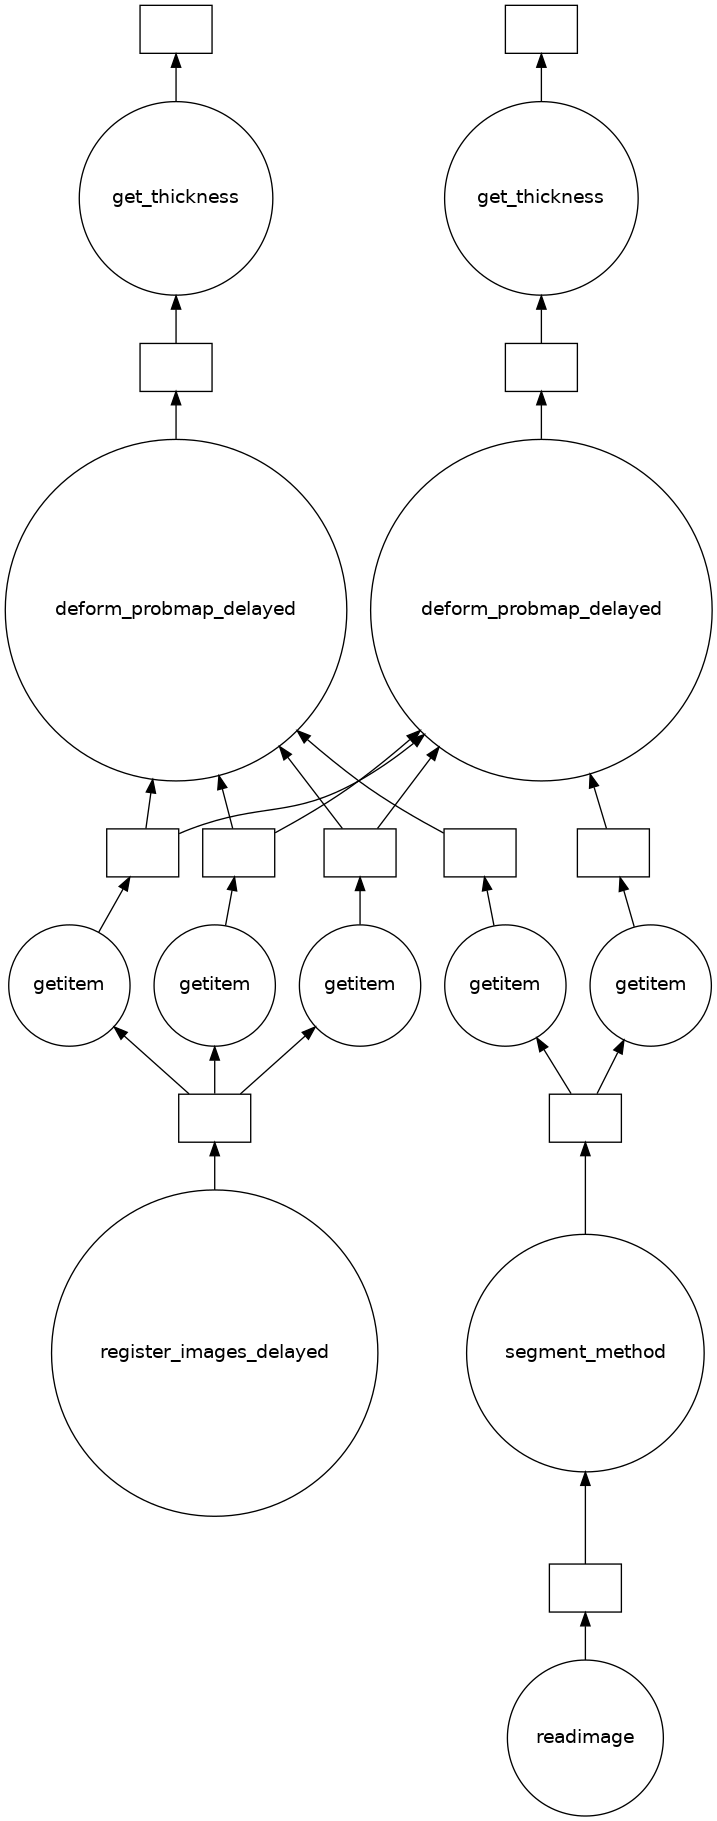

In [6]:
visualize(*all_result)

In [298]:
cluster.close()

2022-08-04 15:54:16,977 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


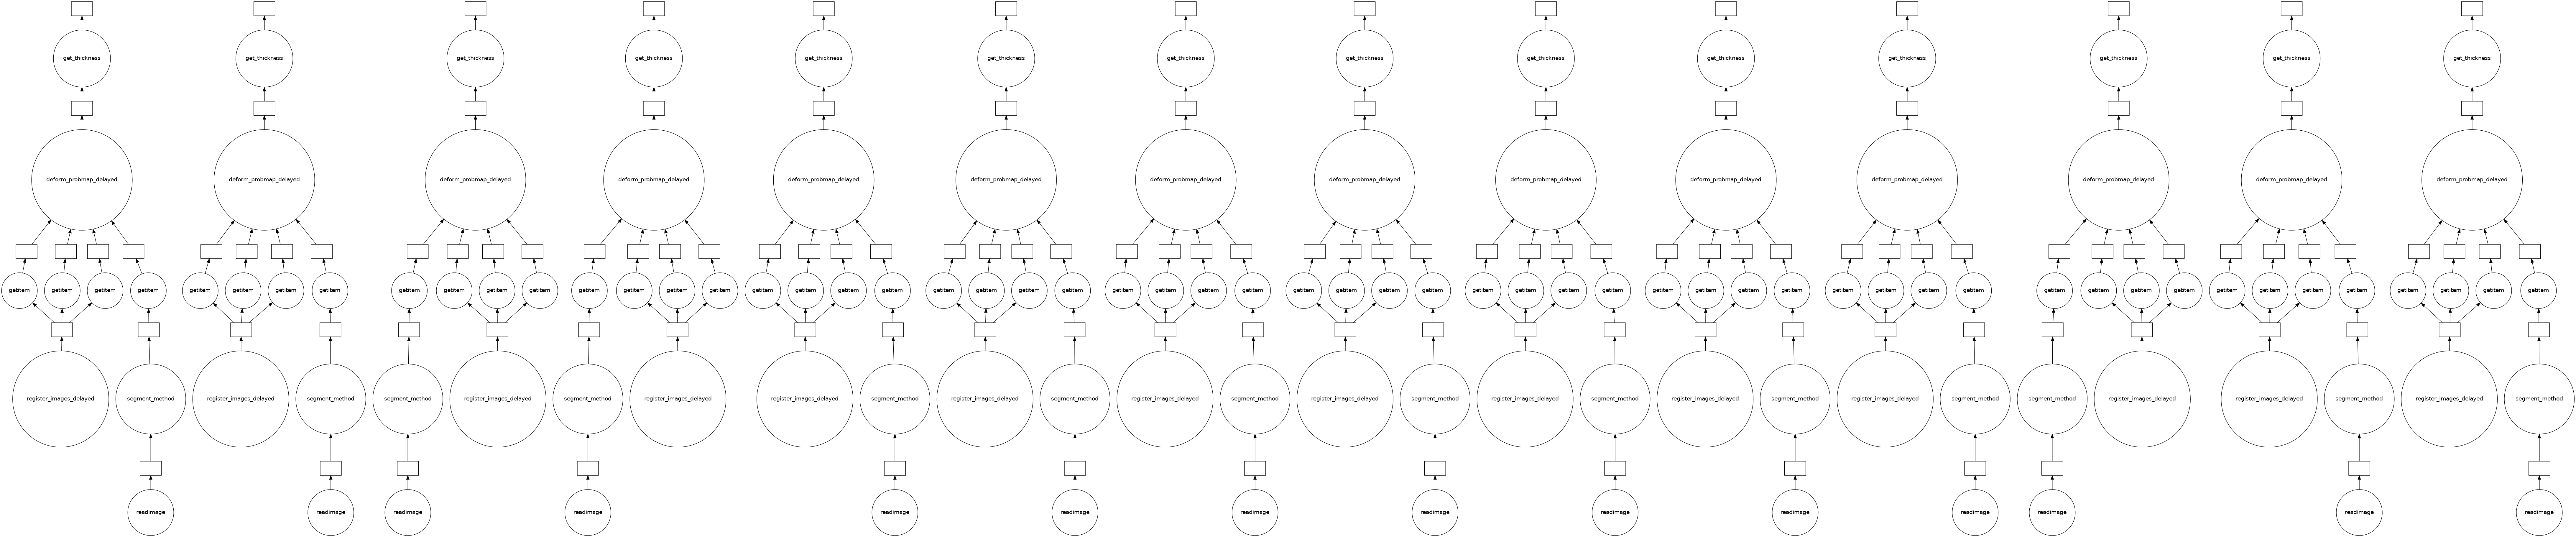

In [262]:
visualize(*all_result)

In [256]:
counter = 0
for result in output_result:
    #itk.meshwrite(result, str(counter)+'_itk_distance_inner_FC.vtk')
    itk.imwrite(result, str(counter)+'_itk_image_fc.nii.gz')
    counter = counter + 1

In [234]:
v1 = vtk.vtkPolyDataReader()
v1.SetFileName('itk_distance_inner_FC.vtk')
v1.Update()
m1 = v1.GetOutput()

itkwidgets.view(geometries=[m1])

<IPython.core.display.Javascript object>

2022-08-04 10:44:02,762 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2022-08-04 10:44:02,763 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [230]:
itk.meshwrite(output_result[0][0], 'itk_distance_inner_FC.vtk')
#itk.meshwrite(output_result[0][1], 'itk_distance_inner_TC.vtk')

In [215]:
cluster.close()

2022-08-04 06:02:28,891 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [ ]:
center = [0,0,0]#np.mean(mesh_cell_centroids, axis=0)
originalPoints = vtk.vtkPoints()
originalPoints.InsertPoint(0, (center[0], center[1], center[2]))
#originalPoints.SetPoints(nps.numpy_to_vtk(center, deep=True))

p2 = vtk.vtkPoints()
p2.SetPoints(nps.numpy_to_vtk(c1, deep=True))

targetPolydata = vtk.vtkPolyData()
targetPolydata.SetPoints(mesh.GetPoints())

# set up locater for intersection with normal vector rays
obbTree = vtk.vtkOBBTree()
obbTree.SetDataSet(targetPolydata)
obbTree.BuildLocator()

class_array = []
for i in range(10):
    rayEndPoint = targetPolydata.GetPoint(i)
    intersectionIds = vtk.vtkIdList()
    intersectionPoints = vtk.vtkPoints()
    k1 = rayEndPoint

In [202]:
import vtk.util.numpy_support as nps
p2 = vtk.vtkPoints()
p2.SetData(nps.numpy_to_vtk(c1, deep=True))

targetPolydata = vtk.vtkPolyData()
targetPolydata.SetPoints(p2)

print(targetPolydata.GetNumberOfPoints())

obbTree = vtk.vtkOBBTree()
obbTree.SetDataSet(targetPolydata)
obbTree.BuildLocator()

100128


2022-08-04 05:41:35.843 (16939.851s) [        82635740]         vtkOBBTree.cxx:1063   ERR| vtkOBBTree (0x55c41a4bc1f0): Can't build OBB tree - no data available!


In [ ]:
#c1 = output_result[0][0]
print(c1.shape)

In [191]:
thickness_fc = get_thickness(img1[0], 'FC')

result = [thickness_fc]
output_result = compute(result)

print(output_result)

([array([[ 37.54342802,  61.00316291,  28.19892024],
       [ 37.59625054,  61.02551295,  27.80814508],
       [ 37.59914358,  60.83415061,  27.93303575],
       ...,
       [121.40625331, 103.17708614,  25.26488211],
       [121.40625331, 103.50230499,  25.20036435],
       [121.55620111, 103.17708614,  25.20036435]])],)


2022-08-04 05:37:18.839 (16682.847s) [         8CDF700]         vtkOBBTree.cxx:1063   ERR| vtkOBBTree (0x7f94f04ec230): Can't build OBB tree - no data available!


In [169]:
print(output_result)

([[5]],)


In [ ]:
img1 = output_result[0]
print(img1[0])

In [107]:
v1 = vtk.vtkPolyDataReader()
v1.SetFileName('itk_distance_inner_FC.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName('itk_distance_inner_TC.vtk')
v2.Update()
m2 = v2.GetOutput()

In [ ]:
!pip install itkwidgets==1.0a6

In [112]:
import itkwidgets
itkwidgets.view(geometries=[m1, m2])

<IPython.core.display.Javascript object>

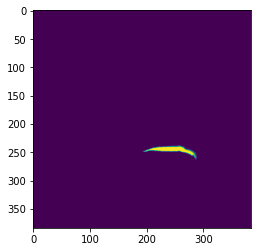

In [97]:
plt.imshow(output_result[0][1][40].astype('float'))

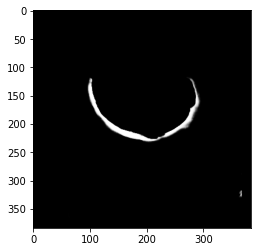

In [67]:
index = 55
import numpy as np

import matplotlib.pyplot as plt
plt.imshow(output_result[0][0][index], cmap='gray')

#temp = np.array(output_result[0][0])
#print(temp.shape)
#plt.hist(temp.flatten())

In [14]:
@delayed
def installitk():
    import subprocess
    output = subprocess.check_output(['pip', 'install', 'itkwidgets'])
    import itkwidgets
    #import os
    #os.system('pip install itkwidgets')
    #time.sleep(60)
    return

t = installitk()
compute(t)

(None,)

In [10]:
output_result[0][1]

<itk.itkImagePython.itkImageD3; proxy of <itk.itkImagePython.itkImageD3; proxy of <Swig Object of type 'itkImageD3 *' at 0x7f964ca2dc60> > >

In [ ]:
# Visualize Dask Computation Graph

visualize(*result)

In [111]:
cluster.close()

2022-08-04 00:57:02,766 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [164]:
# Main execution block

all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'

for month in months_array:
    image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

    fc_probmap, tc_probmap = dp.segment_method(image_path)
    phi_AB, image_A, image_B = dp.register_images_delayed(
        image_path, 'atlas_image.nii.gz')

    deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            fc_probmap, 'FC')
    deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            tc_probmap, 'TC')

    thickness_fc = dp.get_thickness(deformed_fc, 'FC')
    thickness_tc = dp.get_thickness(deformed_tc, 'TC')

    result = [thickness_fc, thickness_tc]

    all_results.append(result)

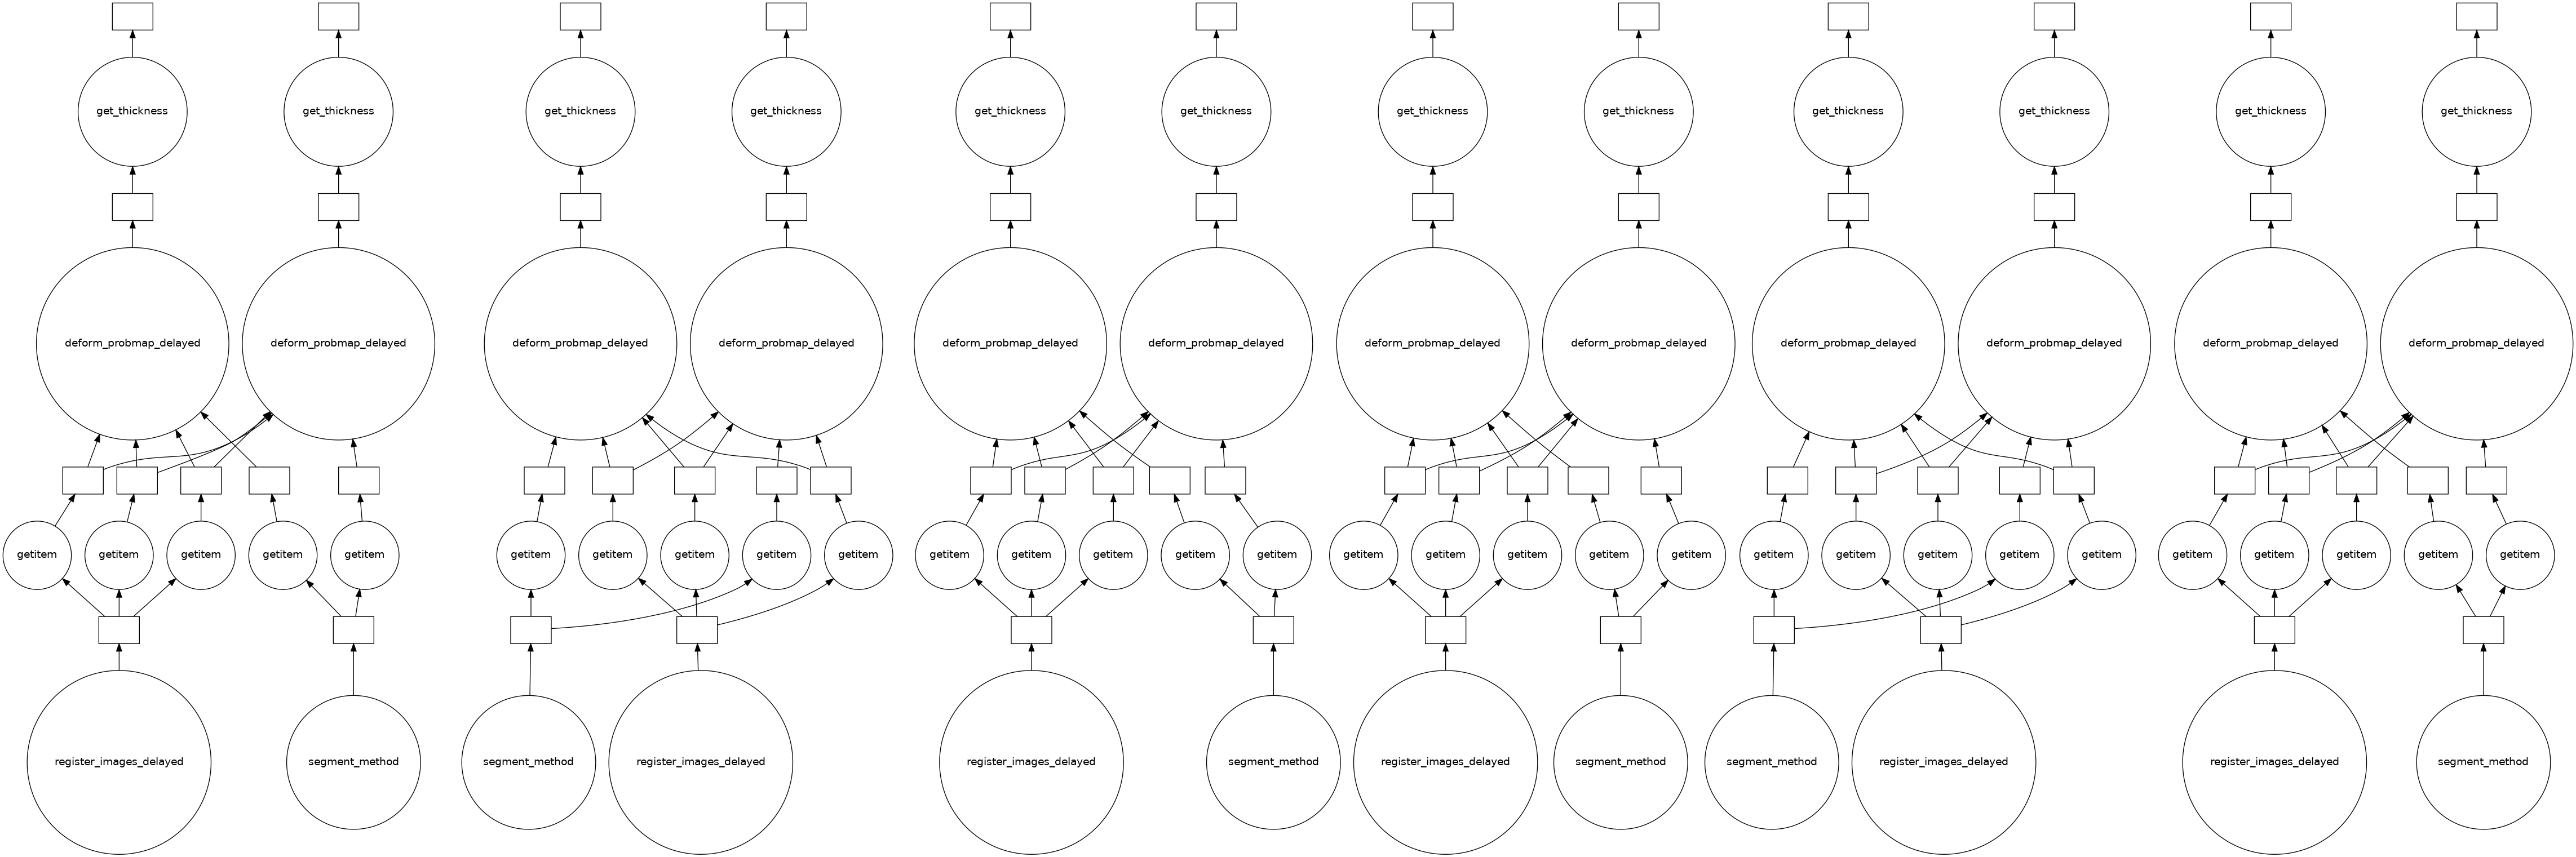

In [165]:
visualize(*all_results)

In [ ]:
#output_result[0].split('\n')
for k in str(output_result[0].decode("utf-8")).split('\n'):
    print(k)

In [ ]:
import zarr
import xarray as xr
import numpy as np

filepath = 's3://oaisample1/ZARRDATA/PatientID-9000798/Month-0/Images/SAG_3D_DESS_0.zarr'

# Read a zarr file and check the laterality
z2 = zarr.open(filepath, mode='r')
print(z2)
image = z2['scale0/image']
image = np.array(image)
#print(image.shape)

p1 = xr.open_zarr(filepath)
#print(p1)
p1
#scale0 = z2['scale0']
#print(scale0.attrs['laterality'])

In [28]:
import xarray as xr

filepath = 's3://oaisample1/ZARRDATA/PatientID-9000798/Month-0/Images/SAG_3D_DESS_0.zarr/scale0'

p1 = xr.open_zarr(filepath)
#print(p1)
p1.dims

Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


Frozen({'z': 160, 'y': 384, 'x': 384})

In [33]:
tuple(p1.dims).index('x')

2

In [35]:
p2 = tuple(['x', 'y'])
p3 = tuple(p2)
p3

('x', 'y')

In [30]:
img1 = itk.imread('/data/ITKPR22/ITK/ITK-build2/ExternalData/Testing/Data/Baseline/IO/cthead1.png', itk.F)
#print(img1.GetMetaDataDictionary())
img1_x = itk.xarray_from_image(img1)
img1_x.dims
#print(img1_x.dims.index('x'))

libpng warning: sCAL: invalid unit


('y', 'x')

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit


In [ ]:
import itk

img1 = itk.imread('/home/pranjal.sahu/Downloads/atlas_fc.nii.gz', itk.F)
#img1 = itk.imread('/data/ITKPR22/ITK/ITK-build2/ExternalData/Testing/Data/Baseline/IO/cthead1.png', itk.F)
#print(img1.shape)
#img1["MyMeta"]= 1.0

x_img = itk.xarray_from_image(img1)
#print(x_img)

#for k in img1.keys():
#    print('Checking key ', k)
#    print(img1[k])


#dict(img1)
#print(img1)
#print(dict(img1))
#print(img1.GetMetaDataDictionary())

In [24]:
@delayed
def getversion():
    import skimage
    return skimage.__version__

out = getversion()
result = compute(out)
print(result)

('0.19.3',)


In [36]:
o1 = img1.GetMetaDataDictionary()
o1.Get('qto_xyz')

RuntimeError: /work/ITK-source/ITK/Modules/Core/Common/src/itkMetaDataDictionary.cxx:77:
ITK ERROR: Key 'qto_xyz' does not exist 

In [14]:
help(itk.down_cast)

Help on function down_cast in module itk.support.extras:

down_cast(obj: 'itkt.LightObject')
    Down cast an itk.LightObject (or a object of a subclass) to its most
    specialized type.



In [ ]:
all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'


# for month in months_array:
#     image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

#     fc_probmap, tc_probmap = dp.segment_method(image_path)
#phi_AB, image_A, image_B = dp.register_images_delayed(
#        image_path, 'atlas_image.nii.gz')
    
#register_images_delayed(image_A, image_B)

In [ ]:
output_result = compute(*all_results)

In [111]:
coiled.create_software_environment(
    name="gpu-test7_temp",
    container="pranjalsahu/pranjal-sahu-gpu-test7")

Creating new software environment
Creating container-only software environment
Successfully saved software environment build


In [156]:
cluster.close()

2022-07-29 17:08:31,540 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [ ]:
coiled.create_software_environment(
    name="gpu-test7",
    container="pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime",
    conda_env_name="base",
    conda={
        "channels": [
            "rapidsai",
            "conda-forge",
            "defaults",
        ],
        "dependencies": [
            "dacoiled.create_software_environment(
    name="gpu-test9",
    container="pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime",
    conda_env_name="base",
    conda={
        "channels": [
            "rapidsai",
            "conda-forge",
            "defaults",
        ],
        "dependencies": [
            "dask",
            "pytorch-gpu",
            "coiled-runtime"
        ],
    }
)sk",
            "pytorch-gpu",
            "python=3.10"
        ],
    }
)

In [ ]:
coiled.create_software_environment(
    name="gpu-test9",
    container="pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime",
    conda_env_name="base",
    conda={
        "channels": [
            "rapidsai",
            "conda-forge",
            "defaults",
        ],
        "dependencies": [
            "dask",
            "pytorch-gpu",
            "coiled-runtime"
        ],
    }
)

In [ ]:
coiled.create_software_environment(
    name="gpu-test10",
    container="pranjalsahu/oaiimageitk:v1",
    conda_env_name="base",
    pip="coiled_requirements.txt"
)